In [6]:
import pandas as pd
import numpy as np
from math import sqrt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    mean_absolute_error,
    mean_squared_error,
)

# Load dataset
df = pd.read_csv(
    "../data/btc_hourly_ohlc_volume_1year_cryptocompare.csv", parse_dates=["timestamp"]
)

# Compute regression target --> next hour price change
df["target"] = df["close"].shift(-1) - df["close"]

# Feature engineering
df["momentum"] = df["close"] - df["open"]
df["volatility_24h"] = df["close"].rolling(window=24).std()
df["sma_24"] = df["close"].rolling(window=24).mean()
df["sma_168"] = df["close"].rolling(window=168).mean()
df["return_1h"] = df["close"].pct_change(1)
df["return_3h"] = df["close"].pct_change(3)
df["return_6h"] = df["close"].pct_change(6)


# Drop NaNs
df.dropna(
    subset=[
        "target",
        "momentum",
        "volatility_24h",
        "sma_24",
        "sma_168",
        "return_1h",
        "return_3h",
        "return_6h",
    ],
    inplace=True,
)

# Binary classification label --> 1 = up, 0 = down/neutral
threshold = 50
df["direction_binary"] = df["target"].apply(lambda x: 1 if x > threshold else 0)

features = [
    "open",
    "high",
    "low",
    "close",
    "volume_btc",
    "volume_usd",
    "momentum",
    "volatility_24h",
    "sma_24",
    "sma_168",
    "return_1h",
    "return_3h",
    "return_6h",
]

# X and targets
X = df[features]
y_class = df["direction_binary"]
y_reg = df["target"]
timestamps = df["timestamp"]

# Time-based split
split_idx = int(len(df) * 0.90)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_class_train, y_class_test = y_class.iloc[:split_idx], y_class.iloc[split_idx:]
y_reg_train, y_reg_test = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]
timestamps_test = timestamps.iloc[split_idx:]

# Train classifier (binary)
clf = XGBClassifier(
    objective="binary:logistic", eval_metric="logloss", n_estimators=100
)
clf.fit(X_train, y_class_train)
y_class_pred = clf.predict(X_test)

# train regressor only on positive-class (up movement)
up_idx = y_class_train == 1
reg = XGBRegressor(objective="reg:squarederror", n_estimators=100)
reg.fit(X_train[up_idx], y_reg_train[up_idx])

# Predict probabilities from classifier
probs = clf.predict_proba(X_test)

# Set a confidence threshold (e.g., 70%)
threshold = 0.35

final_preds = []
for i in range(len(X_test)):
    prob_up = probs[i][1]
    if prob_up > threshold:
        magnitude = abs(reg.predict(X_test.iloc[i : i + 1])[0])
        delta = magnitude
    else:
        delta = 0.0
    final_preds.append(delta)


rmse = sqrt(mean_squared_error(y_reg_test, final_preds))
mae = mean_absolute_error(y_reg_test, final_preds)

print("Classification Report:")
print(classification_report(y_class_test, y_class_pred))

print(f"Blended RMSE: {rmse:.4f}")
print(f"Blended MAE:  {mae:.4f}")

y_class_pred = pd.Series(y_class_pred, index=X_test.index)

y_class_test_series = pd.Series(y_class_test.values, index=X_test.index)

# Build full results DataFrame
results = pd.DataFrame(
    {
        "timestamp": timestamps_test.values,
        "actual_delta": y_reg_test.values,
        "actual_direction": y_class_test_series.values,
        "predicted_direction": y_class_pred.values,
        "predicted_delta": final_preds,
        "predicted_confidence": [probs[i][1] for i in range(len(probs))],
    }
)

# Confident predictions only (where delta was actually generated)
predicted_only = results[results["predicted_delta"] != 0.0]

# Show top 10 confident predictions
print(predicted_only.head(10))

# Summary of confident predictions
num_confident = len(predicted_only)
total_predictions = len(results)
percentage = 100 * num_confident / total_predictions

print(
    f"Confident predictions made: {num_confident} out of {total_predictions} "
    f"({percentage:.2f}%)"
)


from sklearn.metrics import precision_score, recall_score, f1_score

# Get true and predicted directions for confident predictions
y_true_conf = predicted_only["actual_direction"]
y_pred_conf = predicted_only["predicted_direction"]

# Compute classification metrics on confident predictions
precision = precision_score(y_true_conf, y_pred_conf)
recall = recall_score(y_true_conf, y_pred_conf)
f1 = f1_score(y_true_conf, y_pred_conf)

print("Classification Metrics (Confident Predictions Only):")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.72      0.64      5558
           1       0.44      0.30      0.35      4221

    accuracy                           0.54      9779
   macro avg       0.51      0.51      0.50      9779
weighted avg       0.52      0.54      0.52      9779

Blended RMSE: 548.3322
Blended MAE:  391.8502
             timestamp  actual_delta  actual_direction  predicted_direction  \
0  2024-03-08 16:00:00        508.05                 1                    1   
2  2024-03-08 18:00:00        318.91                 1                    0   
7  2024-03-08 23:00:00        -32.18                 0                    0   
8  2024-03-09 00:00:00       -171.45                 0                    1   
9  2024-03-09 01:00:00        260.72                 1                    1   
10 2024-03-09 02:00:00         78.61                 1                    1   
11 2024-03-09 03:00:00         12.69               

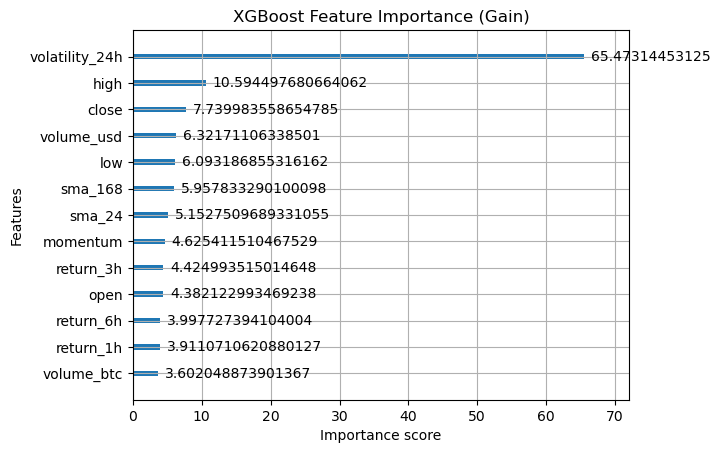

In [7]:
import matplotlib.pyplot as plt

# Plot importance by 'gain' (default is 'weight')
from xgboost import plot_importance

plot_importance(clf, importance_type="gain", max_num_features=15)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

In [8]:
import joblib

joblib.dump(clf, "./btc_xgb_classifier.pkl")

['./btc_xgb_classifier.pkl']